# Parzen Window and Probabilistic Neural Network
Justin Dano

# Part I - Parzen Windows

1. Getting the Data
2. Using Gaussian Density
3. Calculation for Parzen Window
4. Plotting the Parzen Windows
5. Training Parzen Windows
6. Classification with Parzen Windows

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings

In [2]:
# Some configuration
mpl.style.use('seaborn')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
warnings.filterwarnings('ignore')
%matplotlib notebook

## 1. Getting the Data

The .mat files have been downloaded and converted to .csv 

In [3]:
def get_data():
    """
     Extract data from csv
    :return: Tuple of 2-d Numpy Arrays
    """
    d1 = pd.read_csv('hw3_2_1.csv', header=None).transpose().values
    d2 = pd.read_csv('hw3_2_2.csv', header=None).transpose().values
    return d1, d2

In [4]:
d1, d2 = get_data()

In [5]:
d1[0]

array([1.062, 4.269])

In [6]:
d1.shape

(100, 2)

<IPython.core.display.Javascript object>


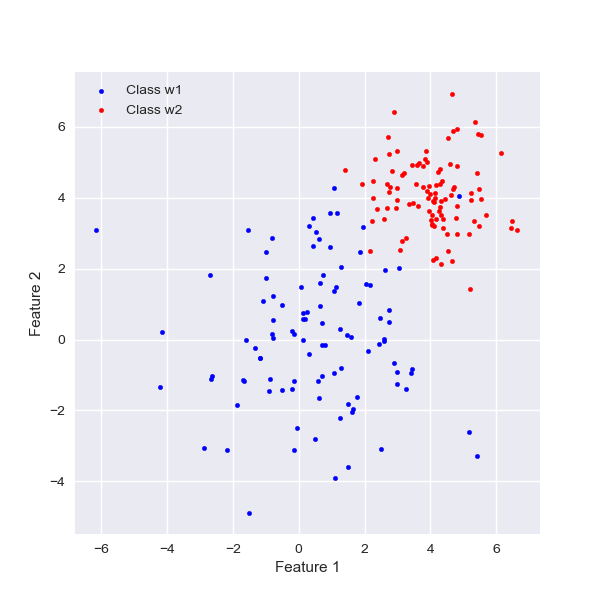

In [7]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(d1[:,0], d1[:,1], s=10, c='b', marker="o", label='Class w1')
ax1.scatter(d2[:,0], d2[:,1], s=10, c='r', marker="o", label='Class w2')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
plt.legend(loc='upper left');
plt.show()

## 2. Using Gaussian Density

![Gauss_Kernel](images/f1_gauss_kernel.PNG "Gaussian Kernel")

In [8]:
def g_kernal(x, x_i, h_n):
    """
    Gaussian Kernel (Window Function)
    :param x:    np.array (2 x 1) - estimation point
    :param x_i:  np.array (2 x 1) - a training sample
    :param h_n:  float            - width window
    :return:     np.array (2 x 1) - result from kernal
    """
    u = (x - x_i) / h_n
    return (1 / np.sqrt(2*np.pi)) * np.exp(-((np.dot(u, u)) / 2))

## 3. Calculation for Parzen Window
![Gauss_Kernel](images/f2_parzen_window.PNG "Parzen Window")

In [9]:
def estimate_density(data, x, h_n):
    """
    For every sample, we estimate the density for a given point
    :param data: np.array (n x 2) - our training data for 1 class
    :param x:    np.array (2 x 1) - estimation point
    :param h_n:  float            - width window
    :return:     float            - parameter estimation for a class
    """
    tot = reduce(lambda a, b: a+b, [(1 / h_n) * g_kernal(x, d, h_n) for d in data])
    return tot / len(data)

For each step in our pre-defined grid, we compute the likelihood estimate from the parzen window for both classes

In [10]:
def compute_parzen_window(d1, d2, g, h_n):
    """
    Estimate Densities of our data using Parzen Window technique
    :param d1:    np.array (n x 2) - dataset belonging to class w1
    :param d2:    np.array (n x 2) - dataset belonging to class w2
    :param g :    list [float]     - set of window steps [-4.0, -3.9 ... , 7.9, 8.0]
    :param h_n:   float            - window width 
    :return:      tuple(np.array)
    """
    px_1 = [estimate_density(d1, np.array([float(i), float(j)]), h_n) for i in g for j in g]
    px_2 = [estimate_density(d2, np.array([float(i), float(j)]), h_n) for i in g for j in g]
    return px_1, px_2

## 4. Plotting the Parzen Windows
The method below builds our four different plots to visualize the parzen-windows for both classes 

In [11]:
def plot_all(x, y, z1, z2):
    """
    Plots multiple 3-d representations of the parzen windows
    let n be total number of steps
    :param x: np.array  (n x n) - meshgrid
    :param y: np.array  (n x n) - meshgrid (transpose of x)
    :param z1: np.array (n x n) - class 1 Likelihood for meshgrid
    :param z2: np.array (n x n) - class 2 Likelihood for meshgrid
    """
    zt1 = z1.copy()
    zt2 = z2.copy()
    zt1[zt1 < 0.0001] = np.nan
    zt2[zt2 < 0.0001] = np.nan
    fig = plt.figure(figsize=(8, 8))
    
    ax1 = fig.add_subplot(2, 2, 1, projection='3d', xlabel='Feature 1', ylabel='Feature 2', title='Class 1')
    s1 = ax1.plot_surface(x, y, z1, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)
    
    ax2 = fig.add_subplot(2, 2, 2, projection='3d', xlabel='Feature 1', ylabel='Feature 2', title='Class 2')
    s1 = ax2.plot_surface(x, y, z2, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)    
    
    ax3 = fig.add_subplot(2, 2, 3, projection='3d', xlabel='Feature 1', ylabel='Feature 2', title='Both Classes')
    s1 = ax3.plot_surface(x, y, z1 + z2, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)
    
    ax4 = fig.add_subplot(2, 2, 4, projection='3d', xlabel='Feature 1', ylabel='Feature 2', title='Both Classes')
    ax4.plot_surface(x, y, zt1, rstride=1, cstride=1, vmin=np.nanmin(zt1), vmax=np.nanmax(zt1), 
                         cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)
    ax4.plot_surface(x, y, zt2, rstride=1, cstride=1, vmin=np.nanmin(z2), vmax=np.nanmax(zt2), 
                         cmap=plt.cm.Spectral, linewidth=0, antialiased=True)   
    
    plt.show()     

## 5. Training Parzen Windows
Complete method for calculating the parzen windows and visualization

In [12]:
def train_parzen_windows(d1, d2, start, end, h_1):
    """
    Performs training for density estimation and graphs the Parzen windows
    :param d1: np.array (n x 2) - our training data for class 1
    :param d2: np.array (n x 2) - our training data class 2
    :param start:           int - min range of our training samples for creating window
    :param end:             int - max range of our training samples for creating window
    :param h_1:           float - window width
    :return: z1, z2: np.array (n x n) - likelihoods for both classes 
    """
    # Start & end index * 10 to handle an iterable as a floating point
    w_start = start * 10
    w_end = (end * 10) + 1

    # Window width is 1 over the sqrt of training samples
    window_width = h_1 / np.sqrt(len(d1))  # 0.2
    g = [p / 10 for p in range(w_start, w_end)]
    p1, p2 = compute_parzen_window(d1, d2, g, window_width)

    x, y = np.meshgrid(g, g)
    z1 = np.reshape(p1, x.shape)
    z2 = np.reshape(p2, x.shape)

    plot_all(x, y, z1, z2)
    return z1, z2

<IPython.core.display.Javascript object>


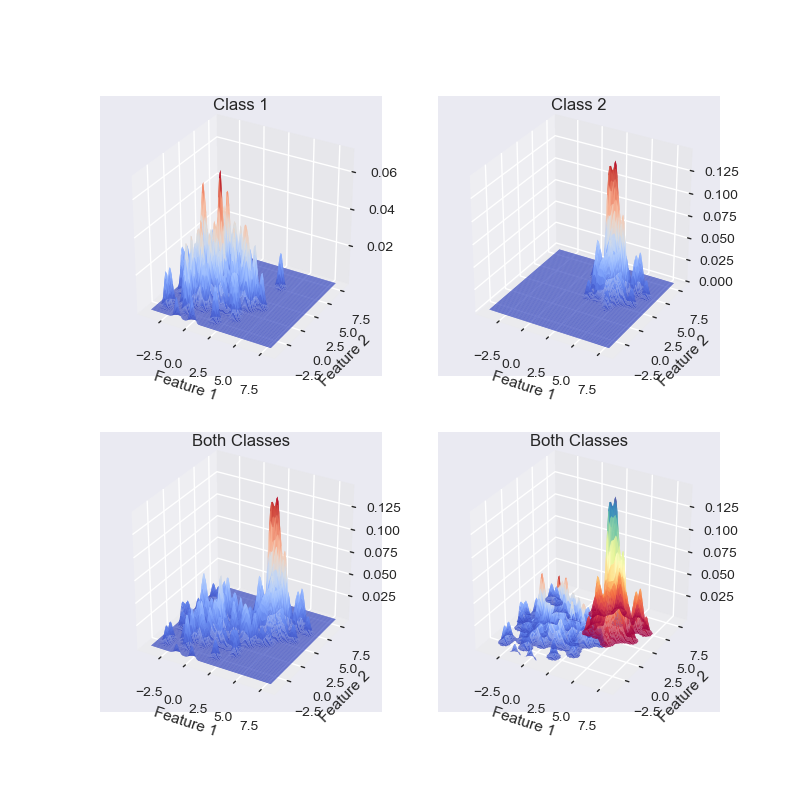

In [13]:
# User-Defined Parameters 
start, stop, h_1 = -4, 8, 2
z1, z2 = train_parzen_windows(d1, d2, start, stop, h_1)

## 6. Classification with Parzen Windows

In [14]:
def classify(x, z1, z2, g):
    """
    Classify a training sample using likelihood from Parzen Windows
    :param x:  np.array (1 x d) - Testing sample for classification
    :param z1: np.array (n x n) - Parzen window likelihood for Class 1
    :param z2: np.array (n x n) - Parzen window likelihood for Class 2
    :param g:      list [float] - set of window steps [-4.0, -3.9 ... , 3.9, 4.0]
    """
    # Get Index for each feature on step list
    x_1 = g.index(x[0])
    x_2 = g.index(x[1])
    # Get Likelihood for each class
    lh_1 = z1[x_1][x_2]
    lh_2 = z2[x_1][x_2]
    print('Likelihood for Class 1: {0:0.4e}'.format(lh_1))
    print('Likelihood for Class 2: {0:0.4e}'.format(lh_2))
    if lh_1 > lh_2:
        print('Sample [{}, {}] belongs to class 1'.format(x[0], x[1]))
    else:
        print('Sample [{}, {}] belongs to class 2'.format(x[0], x[1]))

In [15]:
g = [p / 10 for p in range(-40, 81)]
classify(np.array([1, -2]), z1, z2, g)

Likelihood for Class 1: 6.1638e-03
Likelihood for Class 2: 1.4130e-119
Sample [1, -2] belongs to class 1


In [16]:
classify(np.array([7, 3]), z1, z2, g)

Likelihood for Class 1: 3.7525e-33
Likelihood for Class 2: 3.9771e-03
Sample [7, 3] belongs to class 2


***

# II. Probabalistic Neural Network

1. Getting the Data
2. Normalize Patterns
3. Compute Weight Links
4. PNN Training Algorithm
5. Normalize Test Pattern
6. Define our Net Activation
7. Compute Non-Linear Activation Function
8. PNN Classification Algorithm

## 1. Getting the Data

Same data used in part 1

In [17]:
d1, d2 = get_data()

In [18]:
d1.shape

(100, 2)

In [19]:
d1[0:1]

array([[1.062, 4.269]])

## 2. Normalize Patterns
We want the square of our features to sum to 1 for each sample

![Normalize](images/f3_norm_pattern.PNG "Normalize Pattern")

In [20]:
def normalize_patterns(train_x):
    """
    Square of the features should sum to 1 for each sample
    n - rows (number of samples)
    d - cols (number of features)
    :param train_x: np.array (n x d) - training data
    :return:        np.array (n x d) - Normalized training data
    """
    x = np.zeros((len(train_x), 2))
    s = np.sqrt(np.square(train_x[:,0]) + np.square(train_x[:,1]))
    for col in range(train_x.shape[1]):
        x[:,col] = train_x[:,col] / s
    return x

In [21]:
x1 = normalize_patterns(d1)

In [22]:
x1.shape

(100, 2)

In [23]:
x1[0]

array([0.241, 0.970])

In [24]:
print('Check Squared total is 1 -> {0:0.5f} + {1:0.5f} = {2}'.format(x1[0,0]**2, x1[0,1]**2, x1[0,0]**2 + x1[0,1]**2))

Check Squared total is 1 -> 0.05828 + 0.94172 = 1.0


## 3. Compute Weight Links

For PNN, weight links are simply the input units from the training samples 

In [25]:
def compute_weight_links(d):
    """ Trivial for PNN"""
    return d

In [26]:
w1 = compute_weight_links(x1)

In [27]:
w1.shape

(100, 2)

In [28]:
w1[0]

array([0.241, 0.970])

## 4. PNN Training Algorithm


Training the PNN can be wrapped into a function like this.

In [29]:
def pnn_train(d):
    """
    Train the probablistic neural network
    :param d: np.array(n x d) - training data for 1 class
    :return:  np.array(n x d) - weighted links for same class
    """
    x = normalize_patterns(d)
    w = compute_weight_links(x)
    return w

In [30]:
w1 = pnn_train(d1)
w2 = pnn_train(d2)

In [31]:
w1.shape

(100, 2)

In [32]:
w1[0]

array([0.241, 0.970])

## 5. Normalize Test Pattern

In [33]:
def normalize_test_pattern(x):
    """
    Same normalization technique but for a test pattern
    :param x: np.array(1 x d) - test sample
    :return:  np.array(1 x d) - test sample
    """
    return x / np.sqrt(np.square(x[0]) + np.square(x[1]))


x = np.array([1, -2])
n_x = normalize_test_pattern(x)

In [34]:
n_x

array([0.447, -0.894])

## 6. Define our Net Activation

![net_activation](images/f4_net_activation.PNG "Net Activation")

In [35]:
def compute_net_activation(w, x):
    """
    Net Activation function is the dot product between the weighted links and the test sample
    :param w: np.array(n x d) - weighted links for a class
    :param x: np.array(1 x d) - test sample
    :return: np.array(n x 1)  - our pnn
    """
    return np.sum(w * x, axis=1)

In [36]:
net = compute_net_activation(w1, n_x)

In [37]:
net.shape

(100,)

In [38]:
net[0]

-0.7600095729002455

## 7. Compute Non-Linear Activation Function
![activation_function](images/f5_activate_func.PNG "Activation Function")


In [39]:
def activate_function(net, gww):
    """
    Takes the sum of output units for each activation function
    :param net: np.array(n x 1) - probabilistic neural net for 1 class
    :param gww:           float - Gaussian window width
    :return:              float - output value for a class
    """
    return np.sum(np.exp((net - 1) / gww**2))

In [40]:
gww = 0.2  
activate_function(net, gww)

8.900692659086971

## 8. PNN Classification Algorithm 
Add these together, we get our classifier for the PNN

In [41]:
def pnn_classify(x, w1, w2, gww):
    """
    Classifies a training sample using a probabilistic neural network
    :param x:  np.array(1 x d) - test sample
    :param w1: np.array(n x d) - weighted links for class 1
    :param w2: np.array(n x d) - weighted links for class 2
    :param gww:          float - Gaussian window width
    :return:
    """
    n_x = normalize_test_pattern(x)
    net1 = compute_net_activation(w1, n_x)
    net2 = compute_net_activation(w2, n_x)

    g1 = activate_function(net1, gww)
    g2 = activate_function(net2, gww)
    print('Total output unit for Class 1: {0:0.03f} and Class 2: {1:0.03f}'.format(g1, g2))
    if g1 > g2:
        print('Test Sample:{} belongs to Class 1'.format(x))
    else:
        print('Test Sample:{} belongs to Class 2'.format(x))

In [42]:
gww = 0.2    
d1, d2 = get_data() 
w1 = pnn_train(d1)
w2 = pnn_train(d2)

test_pattern = np.array([1, -2])
pnn_classify(test_pattern, w1, w2, gww)

Total output unit for Class 1: 8.901 and Class 2: 0.000
Test Sample:[ 1 -2] belongs to Class 1


## References
* Lecture notes from Dr. Hong Man (Stevens CPE646 Spring2019)
* https://stackoverflow.com/questions/21918529/multivariate-kernel-density-estimation-in-python
* http://www.grroups.com/blog/kernel-density-estimation-via-the-parzen-rosenblatt-window-method-explained-using-python
